## Response-selective patterns
This code examines basic properties of response-selective neurons

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import date
import time

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['mediumorchid','cornflowerblue','lightcoral','gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f2)
df = df[df['region']=='PER']
df.reset_index(inplace=True,drop=True)

object_bin_all = np.zeros((0,90))
object_peak = []

response_bin_all = np.zeros((0,90))
response_peak = []

for key in df['key']:    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = np.abs(f[key].attrs['selectivity index'])
    
    selective_bin = np.zeros(90)
    selective_bin[f[f'{key}/object_bin']] = 1
    
    if df.loc[df['key']==key,'response cell'].item() == 0:    # object-selective neuron
        object_bin_all = np.append(object_bin_all, [selective_bin], axis=0)
        object_peak.append(df.loc[df['key']==key,'peak_selectivity_time'].item())
    else:    # response-selective neuron
        response_bin_all = np.append(response_bin_all, [selective_bin], axis=0)
        response_peak.append(df.loc[df['key']==key,'peak_selectivity_time'].item())
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1
df['selectivity_onset_range'] = (df['peak_selectivity_time'] // 100) + 1

for i in range(len(df)):
    if df.loc[i,'peak_selectivity_time'] < 200:
        df.loc[i,'peak_selectivity_time_range2'] = 0
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Proportions of cell cateogires

In [8]:
df1 = h5_to_df(f)
df1 = df1[df1['region']=='PER']
df1.reset_index(inplace=True,drop=True)

None cell = 167 (0.48)
Object cell = 149 (0.43)
Response cell = 32 (0.09)


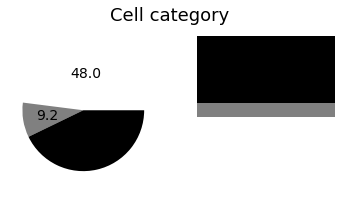

In [9]:
none_cell = df1.groupby('object cell').size()[0]
object_cell = df.groupby('response cell').size()[0]
response_cell = df.groupby('response cell').size()[1]

x = [none_cell, response_cell, object_cell]
color = ['white','gray','black']

fig,ax = plt.subplots(1,2,figsize=(6,3))
fig.suptitle('Cell category', fontsize=18)
ax[0].pie(x,colors=color,autopct='%.1f',textprops={'fontsize':14})
ax[1].axis('off')
prev_data = 0
for i in range(3):
    ax[1].bar(1, height = x[i], bottom=prev_data, color=color[i])
    prev_data += x[i]
    
print(f'None cell = {none_cell} ({none_cell/len(df1):.2f})')
print(f'Object cell = {object_cell} ({object_cell/len(df1):.2f})')
print(f'Response cell = {response_cell} ({response_cell/len(df1):.2f})')

#plt.savefig(fig_path / 'proportion.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'proportion.svg')

### Temporal patterns of response-selective neurons

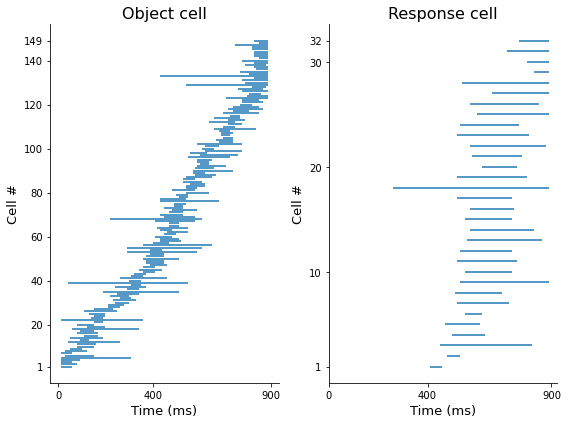

In [11]:
object_sorted = object_bin_all[np.argsort(object_peak)]
response_sorted = response_bin_all[np.argsort(response_peak)]

fig,ax = plt.subplots(1,2,figsize=(8,6))

for i in range(len(object_sorted)):
    s_start = np.min(np.where(object_sorted[i,:]))
    s_end = np.max(np.where(object_sorted[i,:]))
    ax[0].hlines(y=i, xmin = s_start, xmax = s_end)
    
ax[0].set_xticks([0,40,90])
ax[0].set_xticklabels([0,400,900])
ax[0].set_xlabel('Time (ms)',fontsize=13)
ax[0].set_yticks([0, 19, 39, 59, 79, 99, 119, 139, object_cell-1])
ax[0].set_yticklabels([1, 20, 40, 60, 80, 100, 120, 140, object_cell])
ax[0].set_ylabel('Cell #',fontsize=13)
ax[0].set_title('Object cell', fontsize=16)

for i in range(len(response_sorted)):
    s_start = np.min(np.where(response_sorted[i,:]))
    s_end = np.max(np.where(response_sorted[i,:]))
    ax[1].hlines(y=i, xmin = s_start, xmax = s_end)
ax[1].set_xticks([0,40,90])
ax[1].set_xticklabels([0,400,900])
ax[1].set_xlabel('Time (ms)',fontsize=13)
ax[1].set_yticks([0, 9, 19, 29, response_cell-1])
ax[1].set_yticklabels([1, 10, 20, 30, response_cell])
ax[1].set_ylabel('Cell #',fontsize=13)
ax[1].set_title('Response cell', fontsize=16)


plt.tight_layout()
#plt.savefig(fig_path / 'population_selectivity_object_response.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' /'population_selectivity_object_response.svg')

K-S test
KS statistic: 0.46098993288590606
P-value: 1.3269795216541702e-05


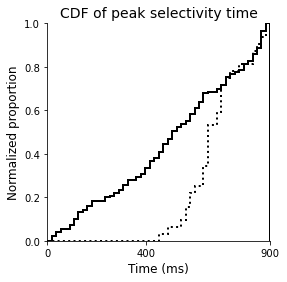

In [22]:
fig,ax = plt.subplots(figsize=(4,4))

ax.hist(response_peak, range=(0,900), bins=50, cumulative=1, histtype='step', density=True, 
        edgecolor='black', linestyle=':', linewidth=2);
ax.hist(object_peak, range=(0,900), bins=50, cumulative=1, histtype='step', density=True,
        edgecolor='black', linewidth=2);


ax.set_ylim([0,1])
ax.set_xticks([0,400,900])
ax.set_xlim([0,900])
ax.set_ylabel('Normalized proportion',fontsize=12);
ax.set_xlabel('Time (ms)',fontsize=12);
ax.set_title('CDF of peak selectivity time',fontsize=14);

s,p = stats.kstest(response_peak, object_peak)
print('================================================')
print("K-S test")
print(f"KS statistic: {s}")
print(f"P-value: {p}")
print('================================================')

#plt.savefig(fig_path / 'peak_time_object_response.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'peak_time_object_response.svg')

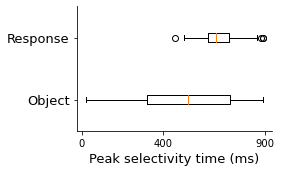

In [15]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = ['Object', 'Response']
y = [object_peak, response_peak]
ax.boxplot(y, vert=False);
ax.set_yticklabels(x, fontsize=13);
ax.set_xticks([0, 400, 900]);
ax.set_xlabel('Peak selectivity time (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_time_boxplot.png', dpi=300,facecolor='white')

In [16]:
pg.mwu(object_peak, response_peak)

,U-val,alternative,p-val,RBC,CLES
MWU,1455.0,two-sided,0.000553,0.389681,0.305159


### Comparing selectivity between object and response cells

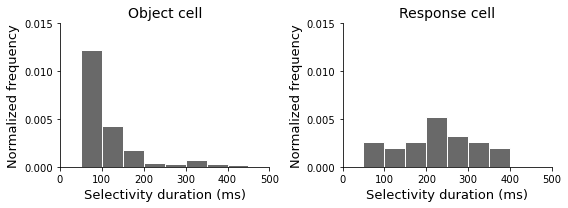

In [19]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(df.loc[df['response cell']==0,'selectivity_duration'], 
           bins=np.arange(0,500,50), color='dimgray', ec='white', density=True);


ax[1].hist(df.loc[df['response cell']==1,'selectivity_duration'], 
           bins=np.arange(0,500,50), color='dimgray', ec='white', density=True);

t = ['Object cell', 'Response cell']
for i in range(2):
    ax[i].set_xlabel('Selectivity duration (ms)',fontsize=13);
    ax[i].set_xticks(np.arange(0,600,100))
    ax[i].set_xlim([0, 500])
    ax[i].set_ylabel('Normalized frequency',fontsize=13);
    ax[i].set_yticks(np.arange(0,0.016,0.005))
    ax[i].set_ylim([0,0.015])
    ax[i].set_title(t[i], fontsize=14)

plt.tight_layout()
#plt.savefig(fig_path / 'selectivity_duration_hist_object_response.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'selectivity_duration_hist_object_response.svg')

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(df.loc[df['response cell']==0,'selectivity_duration'], 
           bins=np.arange(0,500,50), color='dimgray', ec='white', density=True);


ax[1].hist(df.loc[df['response cell']==1,'selectivity_duration'], 
           bins=np.arange(0,500,50), color='dimgray', ec='white', density=True);

t = ['Object cell', 'Response cell']
for i in range(2):
    ax[i].set_xlabel('Selectivity duration (ms)',fontsize=13);
    ax[i].set_xticks(np.arange(0,600,100))
    ax[i].set_xlim([0, 500])
    ax[i].set_ylabel('Normalized frequency',fontsize=13);
    ax[i].set_yticks(np.arange(0,0.016,0.005))
    ax[i].set_ylim([0,0.015])
    ax[i].set_title(t[i], fontsize=14)

plt.tight_layout()
#plt.savefig(fig_path / 'selectivity_duration_hist_object_response.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'selectivity_duration_hist_object_response.svg')z

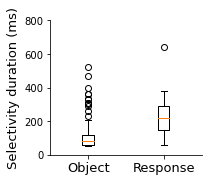

In [26]:
fig,ax = plt.subplots(figsize=(3,2.5))

x = ['Object', 'Response']
y = [df.loc[df['response cell']==0,'selectivity_duration'],
     df.loc[df['response cell']==1,'selectivity_duration']]
ax.boxplot(y);
ax.set_xticklabels(x, fontsize=13);
ax.set_yticks(np.arange(0,900,200));
ax.set_ylabel('Selectivity duration (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'duration_box_object_response.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'duration_box_object_response.svg')

In [22]:
pg.mwu(df.loc[df['response cell']==0,'selectivity_duration'],
     df.loc[df['response cell']==1,'selectivity_duration'])

,U-val,alternative,p-val,RBC,CLES
MWU,832.0,two-sided,6.847353e-09,0.651007,0.174497


----

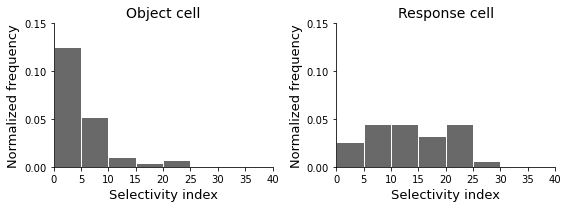

In [23]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(df.loc[df['response cell']==0,'selectivity_index'], 
           bins=np.arange(0,40,5), color='dimgray', ec='white', density=True);


ax[1].hist(df.loc[df['response cell']==1,'selectivity_index'], 
           bins=np.arange(0,40,5), color='dimgray', ec='white', density=True);

t = ['Object cell', 'Response cell']
for i in range(2):
    ax[i].set_xlabel('Selectivity index',fontsize=13);
    ax[i].set_xticks(np.arange(0,45,5))
    ax[i].set_xlim([0, 40])
    ax[i].set_ylabel('Normalized frequency',fontsize=13);
    ax[i].set_yticks(np.arange(0,0.16,0.05))
    ax[i].set_ylim([0,0.15])
    ax[i].set_title(t[i], fontsize=14)

plt.tight_layout()
#plt.savefig(fig_path / 'selectivity_duration_hist.png', dpi=300,facecolor='white')

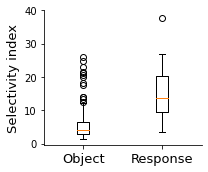

In [25]:
fig,ax = plt.subplots(figsize=(3,2.5))

x = ['Object', 'Response']
y = [df.loc[df['response cell']==0,'selectivity_index'],
     df.loc[df['response cell']==1,'selectivity_index']]
ax.boxplot(y);
ax.set_xticklabels(x, fontsize=13);
ax.set_yticks(np.arange(0,50,10));
ax.set_ylabel('Selectivity index', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_time_boxplot.png', dpi=300,facecolor='white')

In [27]:
pg.mwu(df.loc[df['response cell']==0,'selectivity_index'],
     df.loc[df['response cell']==1,'selectivity_index'])

,U-val,alternative,p-val,RBC,CLES
MWU,638.0,two-sided,8.531037e-11,0.732383,0.133809
